In [1]:
from scipy.io import loadmat
from IPython import display
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
sym.init_printing()

*Prepared by* [**Timothy Kam (甘贊育)**](https://github.com/phantomachine/)

# Working with ``DYNARE++`` from ``Python``

Example from ``Dropbox/_research/AyushiTim/private/dynare``

**Usage.**

1. Write model in ``DYNARE`` markup language and save as a ``.mod`` file. 

    * Example: ``rbcpp.mod``
    * Note slight differences between model file for ``DYNARE++`` and ``DYNARE``.

2. Execute model file using ``DYNARE++``.

    * Example: ``dynare++ rbcpp.mod``
    
3. ``DYNARE++`` generates results file as a ``MATLAB``-style ``.mat`` file.

    * Example: ``rbcpp.mat``.
    
  Use ``Scipy``'s input-output library to import the ``.mat`` file into ``Python``.

    * This will be converted into a ``dict``ionary object.

## Model file for ``DYNARE++``

In [3]:
# Display .mod content (DYNARE++ markdown code) inline
display.Code(filename='rbcpp.mod')

//----------------------------------------------------------------
// RBCPP.mod
//
// DYNARE++ mod file - RBC model 
// (separable log utilities, Cobb-Douglas production)
//
// Modified: T.Kam from original DYNARE example .MOD file
// Changelog: 2022-02-24
//----------------------------------------------------------------

//----------------------------------------------------------------
// 1. Defining variables
//----------------------------------------------------------------

var y c k i l y_l z;
varexo e;

parameters beta psi delta alpha rho;

//----------------------------------------------------------------
// 2. Calibration
//----------------------------------------------------------------

alpha   = 0.33;
beta    = 0.99;
delta   = 0.023;
psi     = 1.75;
rho     = 0.95;
// sigma   = (0.007/(1-alpha)); // place in vcov directly!

//----------------------------------------------------------------
// 3. Model
//----------------------------------------------------------------

model;
  (1/c) = beta*(1/c(+1))*(1+alpha*(k^(alpha-1))*(exp(z(+1)) 
                                         *l(+1))^(1-alpha)-delta);
  psi*c/(1-l) = (1-alpha)*(k(-1)^alpha)*(exp(z)^(1-alpha))
                                                    *(l^(-alpha));
  c+i = y;
  y = (k(-1)^alpha)*(exp(z)*l)^(1-alpha);
  i = k-(1-delta)*k(-1);
  y_l = y/l;
  z = rho*z(-1)+e;
end;

//----------------------------------------------------------------
// 4. Computation
//----------------------------------------------------------------

// Guess of steady-state solution (root-solved)
initval;
  z = 0;
  e = 0;
  k = 2.1;
  c = 0.76;
  l = 0.3;
  y = (k^alpha)*(exp(z)*l)^(1-alpha);
  i = delta*k;
  y_l = y/l; 
end;

// Shock variance (or variance-covariance matrix)
// Here, set: sigma^2
vcov = [ 0.00010915571396747609 ];

// Order of approximation
order = 1;

## Escape to shell and execute ``DYNARE++``

In [4]:
# Run dynare++ executable on model file
!dynare++ rbcpp.mod

## More information on steady-state solution

In [5]:
# Link to display DYNARE++ journal report
display.FileLink(path="rbcpp.jnl")

/Users/obiwan/Dropbox/_research/AyushiTim/private/dynare/rbcpp.jnl

## Import results from ``.mat`` file

In [6]:
# Load saved results using SCIPY IO's loadmat
mod0 = loadmat("rbcpp.mat")

# Working with results ``dict`` object

In [7]:
# See what key names are stored
list(mod0.keys())

['__header__',
 '__version__',
 '__globals__',
 'dyn_vars',
 'dyn_i_y',
 'dyn_i_i',
 'dyn_i_y_l',
 'dyn_i_k',
 'dyn_i_z',
 'dyn_i_c',
 'dyn_i_l',
 'dyn_state_vars',
 'dyn_shocks',
 'dyn_i_e',
 'dyn_vcov_exo',
 'dyn_nstat',
 'dyn_npred',
 'dyn_nboth',
 'dyn_nforw',
 'dyn_steady_states',
 'dyn_g_1',
 'dyn_ss',
 'dyn_mean',
 'dyn_vcov',
 'dyn_irfp_e_mean',
 'dyn_irfp_e_var',
 'dyn_irfm_e_mean',
 'dyn_irfm_e_var']

## Solution as VAR(1) form

Let's focus on a first-order perturbation solution.

In this case, ``DYNARE++`` spits out the solution as a "stacked" linear map. 

To make things concrete, let's use the RBC model example. In this model: 
* There is only one exogenous shock, so the exogenous-shocks vector is just $\tilde{\mathbf{e}}_{t} = e_{t}$ 
* The natural states are $\tilde{\mathbf{s}}_{t} = (k_{t}, z_{t})$
* The dynamic and static controls are $\tilde{\mathbf{x}}_{t} = (y_{t}, i_{t}, y_{l,t}, c_{t}, l_{t})$.




**Warning!** ``DYNARE++`` packs natural state and exogenous shock variables together as the group indexed by the key ``dyn_state_vars``:

In [8]:
dyn_states = mod0["dyn_state_vars"]
dyn_states

array(['k', 'z', 'e'], dtype='<U1')

Let us write the list of all endogenous (forward-looking, static and backward-looking/state) variables as:
$$
\tilde{\mathbf{y}}_{t} = (y_{t}, i_{t}, y_{l,t}, k_{t}, z_{t}, c_{t}, l_{t}).
$$

**Warning!** Pause, observe and think ...

* The natural states $(k,z)$ in this example somehow appear in between the other endogenous variables in the list $\tilde{\mathbf{y}}$. 

* Why do we write the order of endogenous variables this way? 

* *Answer*: This is informed by the internal ordering produced automatically by ``DYNARE++``.


In [9]:
# Our example's y vector
Y = mod0["dyn_vars"]
print(Y)

['y  ' 'i  ' 'y_l' 'k  ' 'z  ' 'c  ' 'l  ']


In [10]:
# Remove excess whitespaces in strings
Y = np.char.strip(Y).tolist()
Y

['y', 'i', 'y_l', 'k', 'z', 'c', 'l']

**Reminder.** ``DYNARE++`` performs Taylor expansions that are centered around the model's risky steady-state point.

Therefore, the variables above are not measured in their original units (levels). They are expressed as linear deviations from their risky steady state.

* Note: The steady state is by default adjusted for risk by ``DYNARE++`` (Jensen's inequality). 

* This risky steady state will be different from the non-stochastic steady state of the model in general. 

* See [Courdacier, Rey and Winant (2011)](https://www.aeaweb.org/articles?id=10.1257/aer.101.3.398) to understand why.

In our example, we now work with these "centered" variables in the solution:

* The natural states are $\mathbf{s}_{t} = (k_{t}-k, z_{t}-z)$

* The exogenous-shocks vector is just $\mathbf{e}_{t} = e_{t}-e$ 

* The dynamic and static controls are $\mathbf{x}_{t} = (y_{t}-y, i_{t}-i, y_{lt}-y_{l}, c_{t}-c, l_{t}-l)$.

* All endogenous states and controls are listed in $\mathbf{y}_{t}$.

**Notation.**

* The risk-adjusted (risky) levels of steady-state vectors are denoted here without $t$-subscripts: $(\tilde{\mathbf{s}}, \tilde{\mathbf{e}}, \tilde{\mathbf{x}}, \tilde{\mathbf{y}})$.


Let's see what this looks like "on paper":

In [11]:
# Create symbolic vector y (deviations from risky steady state)
Y_now = ['y_{t}-y', 'i_{t}-i', 'y_{lt}-y_{l}', 'k_{t}-k', 'z_{t}-z', 'c_{t}-c', 'l_{t}-l']
Y_sym = sym.Matrix([ sym.symbols(y) for y in Y_now ])

The above vector collects the endogenous variables expressed as linear deviations from their respective risky steady states.

In [12]:
# Create symbolic vector (z, e)
dyn_stateshock = ['k_{t-1}-k', 'z_{t-1}-z', 'e_{t}-e']
sts_sym = sym.Matrix([sym.symbols(s) for s in dyn_stateshock])

In [13]:
# Make G symbolic
G = mod0['dyn_g_1']
G_sym = sym.Matrix(G)

``DYNARE++`` presents the solution in this stacked VAR(1) form:

\begin{equation}
    (\mathbf{y}_{t}) = \mathbf{G}\left(
                                    \begin{matrix}
                                    \mathbf{s}_{t-1}
                                    \\
                                    \mathbf{e}_{t}
                                    \end{matrix}
                                \right)
    \label{eq:dynare-var1}
\end{equation}

Verbosely, this is:

In [14]:
lhs = Y_sym
rhs = sym.MatMul(G_sym, sts_sym)
sym.Eq(lhs, rhs)

⎡  y_{t}-y   ⎤   ⎡0.0161128029385585   0.971375524644278  1.02250055225713 ⎤  
⎢            ⎥   ⎢                                                         ⎥  
⎢  i_{t}-i   ⎥   ⎢-0.025554467771189   0.766310861535365  0.806643012142489⎥  
⎢            ⎥   ⎢                                                         ⎥  
⎢y_{lt}-y_{l}⎥   ⎢ 0.124945226434168    1.5069921820183   1.58630756001927 ⎥ ⎡
⎢            ⎥   ⎢                                                         ⎥ ⎢
⎢  k_{t}-k   ⎥ = ⎢ 0.951445532228812   0.766310861535364  0.806643012142489⎥⋅⎢
⎢            ⎥   ⎢                                                         ⎥ ⎢
⎢  z_{t}-z   ⎥   ⎢        0.0                0.95                1.0       ⎥ ⎣
⎢            ⎥   ⎢                                                         ⎥  
⎢  c_{t}-c   ⎥   ⎢0.0416672707097476   0.205064663108913  0.215857540114646⎥  
⎢            ⎥   ⎢                                                         ⎥  
⎣  l_{t}-l   ⎦   ⎣-0.0081693815535261  0.15182283751

# Using DYNARE++ solution as guess for global solutions

**Background.** When we solve Euler equation systems nonlinearly and globally (e.g., time-iteration methods), we will see that the solution can often be expressed as a nonlinear state space form:

$$
\begin{split}
\tilde{\mathbf{s}}_{t} &= T(\tilde{\mathbf{s}}_{t-1}, \tilde{\mathbf{e}}_{t}),
\\
\tilde{\mathbf{x}}_{t} &= K(\tilde{\mathbf{s}}_{t}),
\end{split}
$$

where $T$ and $K$ are non-linear, vector valued functions.

To initialize a time-iteration method, we often need a good guess of the policy function. The local, linear approximate solution is typically used.

The local, linear solution, i.e., the ``DYNARE++`` solution above, is equivalent to a linear-state space representation,
\begin{equation}
    \begin{split}
    \mathbf{s}_{t} &= \mathbf{A}\mathbf{s}_{t-1} + \mathbf{B}\mathbf{e}_{t},
    \\
    \mathbf{x}_{t} &= \mathbf{F}\mathbf{s}_{t},
    \end{split}
    \label{eq:linear-ss-sol}
\end{equation}
where $\mathbf{F}$ is a linear map which is the equilibrium or optimal control function.



* Note that if we plug the first line into the second in Equation \eqref{eq:linear-ss-sol}, we will get back the ``DYNARE++`` "stacked VAR(1)" solution form in Equation \eqref{eq:dynare-var1}.


**Caveat emptor!** 

Recall that ``DYNARE++`` has its own internal solution ordering of variables. 

* See discussion/example above where $\mathbf{s}_{t}$ gets spliced in between elements of $\mathbf{x}_{t}$ to make up the vector $\mathbf{y}_{t}$.

Looking ahead, we will need to extract the correct row elements from the solution array ``mod0["dyn_g_1"]``.

*Example*:

1. ``DYNARE++`` produces solution in the form of Equation \eqref{eq:dynare-var1}. It may not split states and controls cleanly. For example, ``DYNARE++`` ends up partitioning the list of controls, $\mathbf{x}_{t} = (\mathbf{x}^{1}_{t}, \mathbf{x}^{2}_{t})$ and gives us $\mathbf{y}_{t} = (\mathbf{x}^{1}_{t}, \mathbf{s}_{t}, \mathbf{x}^{2}_{t})$.

2. Then we need to row-sort from Equation \eqref{eq:linear-ss-sol} and write:

    \begin{equation}
    \begin{split}
    \mathbf{s}_{t} &= \mathbf{A}\mathbf{s}_{t-1} + \mathbf{B}\mathbf{e}_{t},
    \\
    \mathbf{x}^{1}_{t} &= \mathbf{F}_{1}\mathbf{s}_{t},
    \\
    \mathbf{x}^{2}_{t} &= \mathbf{F}_{2}\mathbf{s}_{t},
    \end{split}
    \label{eq:linear-ss-sol-partition}
    \end{equation}
    
   where $\mathbf{F} = [ \mathbf{F}_{1}, \mathbf{F}_{2} ]^{T}$.
    
3. Now plug the solution's state transition equation into the split control rules, and row-sort:

    \begin{equation}
    \begin{split}
    \mathbf{x}^{1}_{t} &= \mathbf{F}_{1}(\mathbf{A}\mathbf{s}_{t-1} + \mathbf{B}\mathbf{e}_{t}),
    \\
    \mathbf{s}_{t} &= \mathbf{A}\mathbf{s}_{t-1} + \mathbf{B}\mathbf{e}_{t},
    \\
    \mathbf{x}^{2}_{t} &= \mathbf{F}_{2}(\mathbf{A}\mathbf{s}_{t-1} + \mathbf{B}\mathbf{e}_{t}),
    \end{split}
    \label{eq:linear-ss-sol-partition-subbed}
    \end{equation}
   

So we reproduced ``DYNARE++``'s solution form in Equation \eqref{eq:dynare-var1}, noting that:
   
\begin{equation}
\mathbf{G} = \begin{pmatrix}
           \mathbf{F}_{1}\mathbf{A} & \mathbf{F}_{1}\mathbf{B}
           \\
           \mathbf{A} & \mathbf{B}
           \\
           \mathbf{F}_{2}\mathbf{A} & \mathbf{F}_{2}\mathbf{B}
            \end{pmatrix}.
\end{equation}

**Our task is now the reverse**: Rewrite the ``DYNARE++`` solution form as the linear state-space form \eqref{eq:linear-ss-sol}.

1. ``DYNARE++`` only gives us $\mathbf{G}$.

2. Determine row(s) containing sub-maps $\mathbf{A}$ and $\mathbf{B}$ that identifies the natural states $\mathbf{s}_{t}$.

3. Define the arrays $\mathbf{A}$ and $\mathbf{B}$ accordingly.

4. Given $\mathbf{A}$ (always a square, invertible matrix), or given or $\mathbf{B}$, we can now back out $\mathbf{F}$.

In [15]:
# Get indices of state variables 'k' and 'z' from Y = mod0["dyn_vars"]:
idx_k = Y.index('k')
print("Index of k is ... ", idx_k)

idx_z = Y.index('z')
print("Index of z is ... ", idx_z)

Index of k is ...  3
Index of z is ...  4


We could have also gotten the same information above by accessing the variables' index key in the dictionary ``mod0``:

In [16]:
# "minus 1" at the end since DYNARE++ indexes elements from 1 (like MATLAB)
print("Index of k is ... ", mod0["dyn_i_k"].astype(int).item()-1)
print("Index of z is ... ", mod0["dyn_i_z"].astype(int).item()-1)

Index of k is ...  3
Index of z is ...  4


In [17]:
# DYNARE++ solution
G

array([[ 0.0161128 ,  0.97137552,  1.02250055],
       [-0.02555447,  0.76631086,  0.80664301],
       [ 0.12494523,  1.50699218,  1.58630756],
       [ 0.95144553,  0.76631086,  0.80664301],
       [ 0.        ,  0.95      ,  1.        ],
       [ 0.04166727,  0.20506466,  0.21585754],
       [-0.00816938,  0.15182284,  0.15981351]])

In [18]:
# Solution's state transition law (state-space form)
A = G[[idx_k, idx_z], 0:2]
A_sym = sym.Matrix(A)

B = G[[idx_k, idx_z], -1]
B_sym = sym.Matrix(B)

In [19]:
# Create index list to pick out non-state variables from y
select_rows = np.delete(np.arange(G.shape[0]), [idx_k, idx_z])
select_rows

array([0, 1, 2, 5, 6])

In [20]:
# Exclude rows corresponding to natural state variables
F_temp = G[select_rows, 0:2]
F_temp

array([[ 0.0161128 ,  0.97137552],
       [-0.02555447,  0.76631086],
       [ 0.12494523,  1.50699218],
       [ 0.04166727,  0.20506466],
       [-0.00816938,  0.15182284]])

In [21]:
# Back out solution's control function
F = F_temp@np.linalg.inv(A)
F_sym = sym.Matrix(F)

In [22]:
# Symbolic vectors
s_sym = sym.Matrix([sym.symbols(s) for s in dyn_stateshock[0:2]])
e_sym = sym.symbols(dyn_stateshock[-1])
snext_sym = sym.Matrix([sym.symbols(s) for s in ['k_{t}-k', 'z_{t}-z']])

Let's see this example verbosely.

The solution's state transition law ($\mathbf{A}$, $\mathbf{B}$) is:

In [23]:
LHS = snext_sym
RHS = sym.MatAdd(sym.MatMul(A_sym, s_sym), sym.MatMul(B_sym, e_sym))
sym.Eq(LHS, RHS)

⎡k_{t}-k⎤   ⎡0.951445532228812  0.766310861535364⎤ ⎡k_{t-1}-k⎤   ⎡0.8066430121
⎢       ⎥ = ⎢                                    ⎥⋅⎢         ⎥ + ⎢            
⎣z_{t}-z⎦   ⎣       0.0               0.95       ⎦ ⎣z_{t-1}-z⎦   ⎣       1.0  

42489⎤        
     ⎥⋅e_{t}-e
     ⎦        

The solution's (equilibrium) responses ($\mathbf{F}$) to the state of the model economy are

In [24]:
# Create symbolic vector x
x_now = ['y_{t}-y', 'i_{t}-i', 'y_{lt}-y_{l}', 'c_{t}-c', 'l_{t}-l']
x_sym = sym.Matrix([ sym.symbols(x) for x in x_now ])

In [25]:
LHS = x_sym
RHS = sym.MatMul(F_sym, s_sym)
sym.Eq(LHS, RHS)

⎡  y_{t}-y   ⎤   ⎡ 0.0169350765679812   1.00883999108347 ⎤            
⎢            ⎥   ⎢                                       ⎥            
⎢  i_{t}-i   ⎥   ⎢ -0.026858571411152   0.828308291087425⎥            
⎢            ⎥   ⎢                                       ⎥ ⎡k_{t-1}-k⎤
⎢y_{lt}-y_{l}⎥ = ⎢ 0.131321470543329    1.48037801346121 ⎥⋅⎢         ⎥
⎢            ⎥   ⎢                                       ⎥ ⎣z_{t-1}-z⎦
⎢  c_{t}-c   ⎥   ⎢ 0.0437936479791332   0.18053169999605 ⎥            
⎢            ⎥   ⎢                                       ⎥            
⎣  l_{t}-l   ⎦   ⎣-0.00858628400344567  0.166739579169052⎦            

So we have our example of the state-space solution in Equation \eqref{eq:linear-ss-sol}.

If you need to explicitly write this in terms of the variables' original units (i.e., in levels form), then it's just another step of algebra to express the linear state-space form as as affine system:

\begin{equation}
    \begin{split}
    \tilde{\mathbf{s}}_{t} &= \mathbf{c} + \mathbf{A}\tilde{\mathbf{s}}_{t-1} + \mathbf{B}\tilde{\mathbf{e}}_{t},
    \\
    \tilde{\mathbf{x}}_{t} &= \mathbf{d} + \mathbf{F}\tilde{\mathbf{s}}_{t},
    \end{split}
    \label{eq:linear-ss-sol-levels}
\end{equation}

where $\mathbf{c} = (\mathbf{I}-\mathbf{A})\tilde{\mathbf{s}}-\mathbf{B}\tilde{\mathbf{e}}$ and $\mathbf{d} = \tilde{\mathbf{x}}-\mathbf{F}\tilde{\mathbf{s}}$.

# Analyzing results

The model solution's behavior can be studied using some common time-series statistics:

* Impulse response functions

* Stochastic steady-state distribution

## Impulse responses as linear deviations (default)

In [26]:
# DYNARE++ irf - positive e shock, size σ
irfp = mod0["dyn_irfp_e_mean"].T
irfp = pd.DataFrame(irfp)
irfp.columns = Y

Note that ``DYNARE++`` reports the impulse responses as follows:

* Endogenous state variables (except shock processes, e.g., $z$) as linear deviations from steady state.

* Endogenous state variables (for shock processes, e.g., $z$) are in log-linear (percentage) deviations from log of steady state values.

In [27]:
irfp.head()

,y,i,y_l,k,z,c,l
0,0.010683,0.008428,0.016573,0.008428,0.010448,0.002255,0.001670
1,0.010284,0.007791,0.016798,0.016025,0.009925,0.002494,0.001517
2,0.009899,0.007196,0.016960,0.022853,0.009429,0.002703,0.001376
3,0.009527,0.006642,0.017065,0.028969,0.008958,0.002886,0.001245
4,0.009168,0.006124,0.017119,0.034426,0.008510,0.003044,0.001123


In [28]:
irfp.tail()

,y,i,y_l,k,z,c,l
95,0.000193,-0.000113,0.000993,0.006660,0.000080,0.000306,-0.000044
96,0.000185,-0.000109,0.000953,0.006398,0.000076,0.000294,-0.000042
97,0.000177,-0.000105,0.000914,0.006145,0.000072,0.000282,-0.000041
98,0.000169,-0.000102,0.000877,0.005902,0.000069,0.000271,-0.000039
99,0.000162,-0.000098,0.000841,0.005668,0.000065,0.000260,-0.000038


<IPython.core.display.Javascript object>


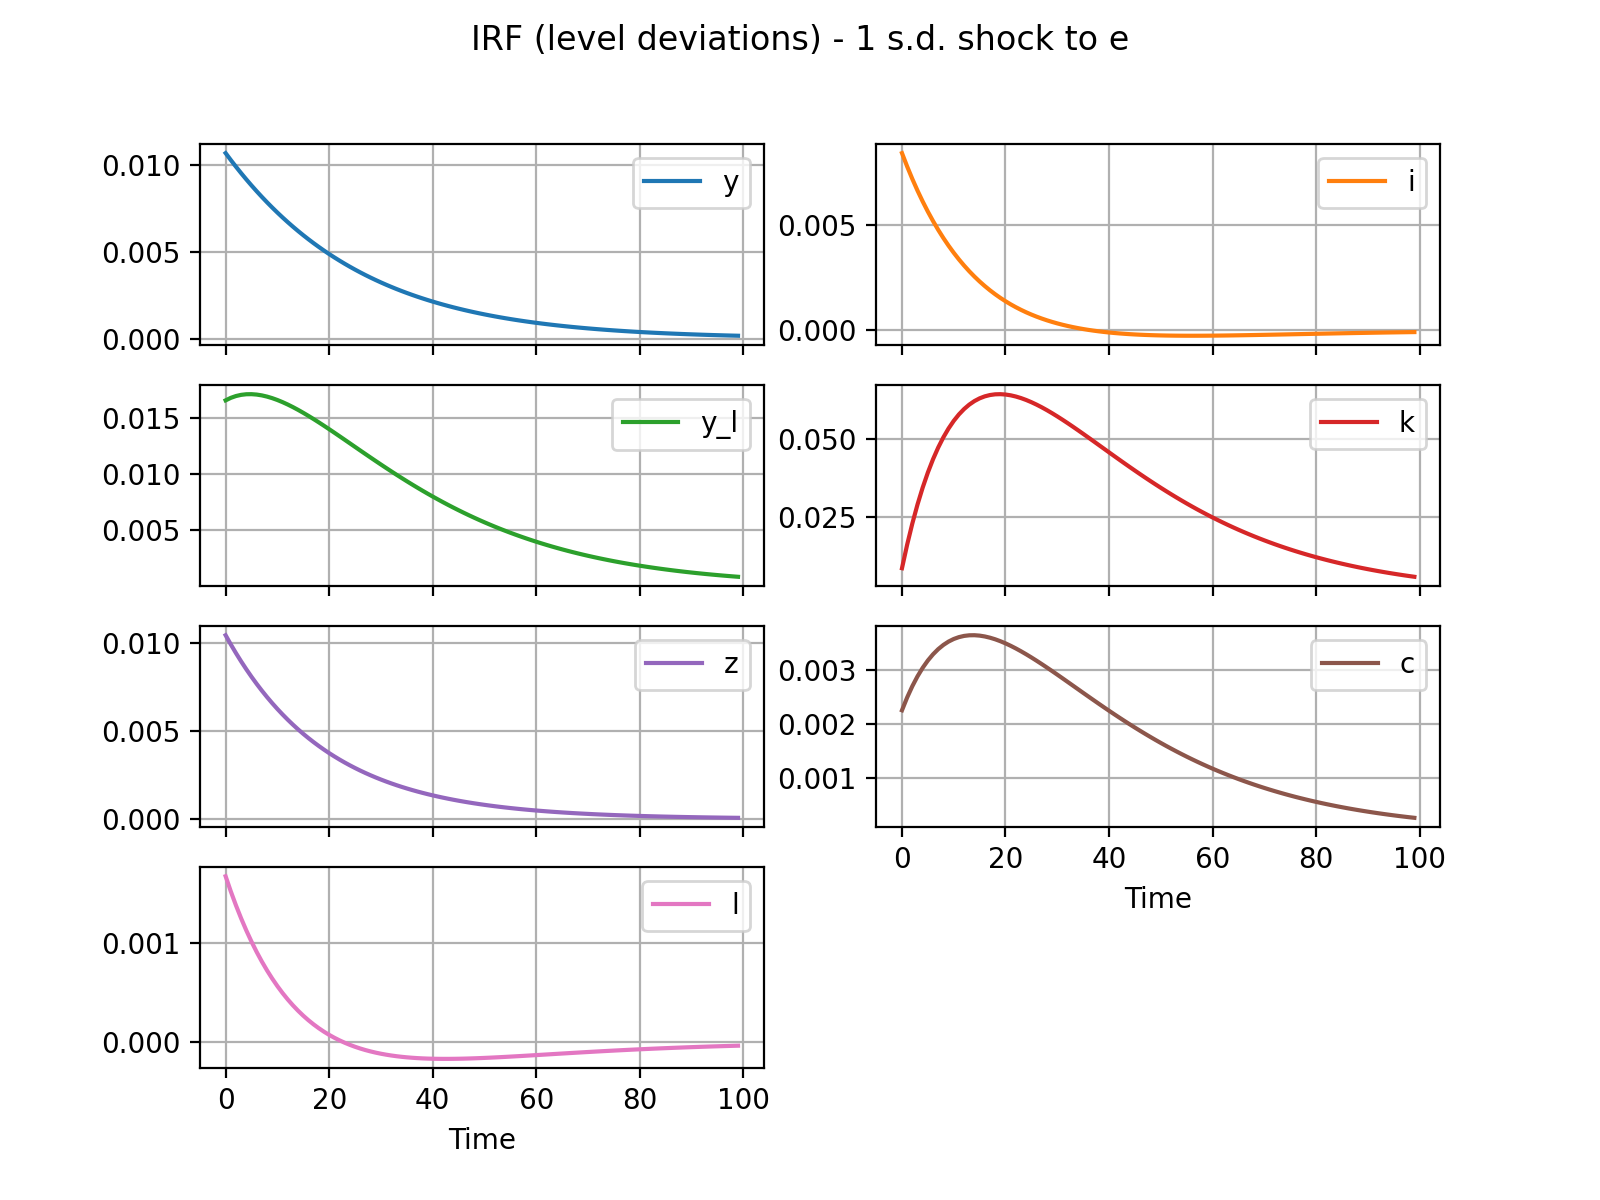

In [29]:
irfp.plot(subplots=True, 
           layout=(4,2),
           grid=True,
           figsize=(8,6),
           xlabel="Time",
           title="IRF (level deviations) - 1 s.d. shock to e"
          )
plt.show(block=False)

### Impulse responses in levels

Model steady state values:

In [30]:
sstate = pd.DataFrame(mod0["dyn_steady_states"], 
                      columns=["Steady State Value"], 
                      index=irfp.columns)
sstate

,Steady State Value
y,1.030103e+00
i,2.362006e-01
y_l,3.103727e+00
k,1.026959e+01
z,8.364706e-18
c,7.939020e-01
l,3.318921e-01


**Note.** Again note that the state $z$ here is measured in logarithms! All other endogenous variables are in their original level units.

Just add back the vector of steady state values:

In [31]:
# Repeat sstate in tiled array, same shape as irfp
ss = np.tile(sstate.T, (irfp.shape[0],1))

# Redo IRFs in levels
irfp_level = irfp + ss
irfp_level

,y,i,y_l,k,z,c,l
0,1.040785,0.244628,3.120301,10.278020,0.010448,0.796157,0.333562
1,1.040387,0.243991,3.120525,10.285617,0.009925,0.796396,0.333409
2,1.040002,0.243397,3.120687,10.292445,0.009429,0.796605,0.333268
3,1.039630,0.242842,3.120792,10.298561,0.008958,0.796788,0.333137
4,1.039271,0.242325,3.120846,10.304019,0.008510,0.796946,0.333015
...,...,...,...,...,...,...,...
95,1.030296,0.236088,3.104720,10.276252,0.000080,0.794208,0.331848
96,1.030288,0.236092,3.104680,10.275990,0.000076,0.794196,0.331850
97,1.030280,0.236095,3.104641,10.275738,0.000072,0.794184,0.331851
98,1.030272,0.236099,3.104604,10.275494,0.000069,0.794173,0.331853


<IPython.core.display.Javascript object>


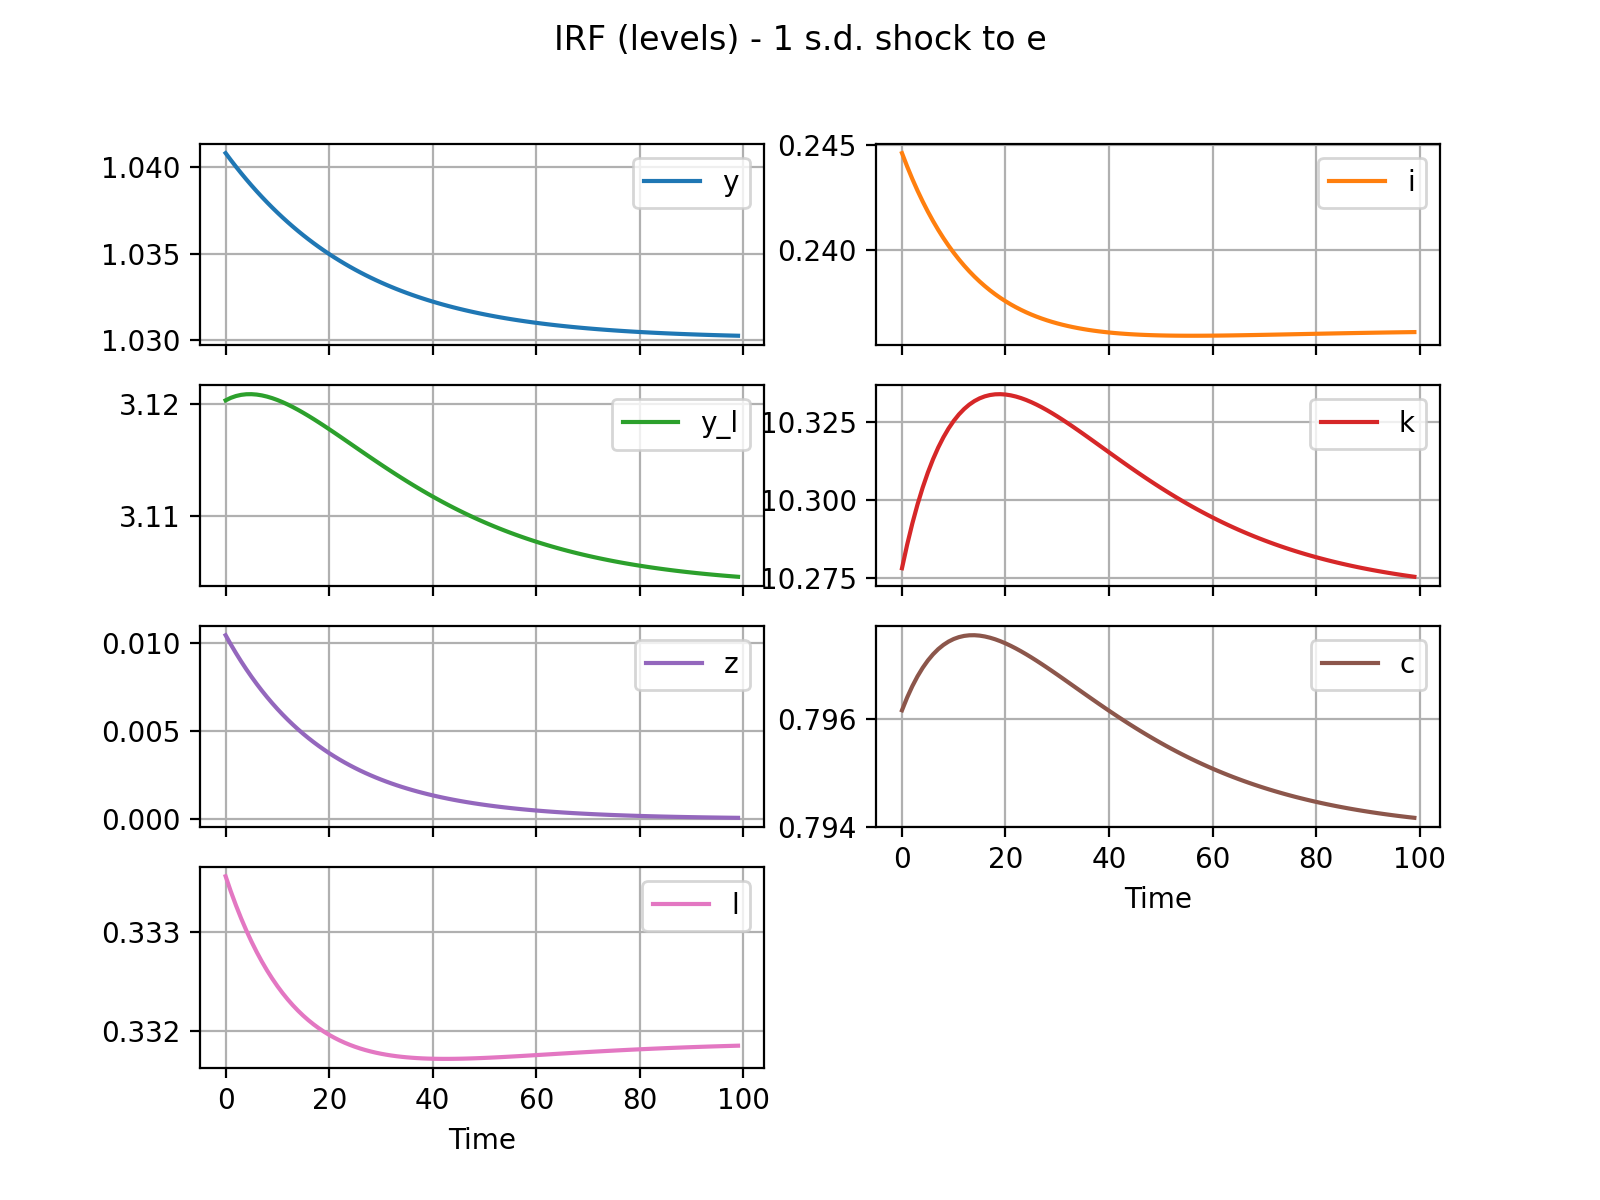

In [32]:
irfp_level.plot(subplots=True, 
           layout=(4,2),#
           grid=True,
           figsize=(8,6),
           xlabel="Time",
           title="IRF (levels) - 1 s.d. shock to e"
          )
plt.show(block=False)

### Verifying the two approaches

We now do a check that our manually derived state-space form is consistent with ``DYNARE++``'s result. 

Let's visualize this through the two approaches' impulse response statistics.

In [33]:
def statespace_names(mod):
    shock_names = mod['dyn_shocks']
    stateshock_names = mod['dyn_state_vars']
    bool_flip = ~np.isin(stateshock_names, shock_names)
    state_names = stateshock_names[bool_flip]
    all_names = np.char.strip(mod0["dyn_vars"])
    control_names = all_names[~np.isin(all_names, state_names)]
    return shock_names, state_names, control_names, all_names

In [34]:
def statespace_irf(mod, A, B, F, T=100, 
                                 level=True, 
                                 positive_shock=True, 
                                 unit_shock=False):
    """Given state-space model and 1 s.d. shock to e,
        \begin{equation}
            \begin{split}
            \mathbf{s}_{t} &= \mathbf{A}\mathbf{s}_{t-1} 
                            + \mathbf{B}\mathbf{e}_{t},
            \\
            \mathbf{x}_{t} &= \mathbf{F}\mathbf{s}_{t},
            \end{split}
        \end{equation}
    compute impulse response functions for states (s) and
    controls (observations) (x).
    """
    # Names: shocks, states, controls, all-endo (DYNARE)
    e_names, s_names, x_names, Y_names = statespace_names(mod)
    # Get steady state values
    y_ss = mod["dyn_steady_states"].flatten()
    s_ss = y_ss[np.isin(Y_names, s_names)].flatten()
    x_ss = y_ss[~np.isin(Y_names, s_names)].flatten()
    # Shock size
    σ = np.sqrt(mod["dyn_vcov_exo"])
    # Option for unit and/or negative shock
    if unit_shock==True:
        σ = 1.0
    if positive_shock==False:
        σ = -σ
    # Store IRF (state, control) outcomes
    s = []
    x = []
    # Initial state
    s_prev = np.zeros(s_ss.shape)

    # Recursive IRF definition
    for t in range(T): 
        if t==0:
            # Shock assumed for t=0
            s_now = A@s_prev + B*σ
        else:
            # Deterministic otherwise
            s_now = A@s_prev
        # Flatten - DYNARE arrays are 2d!
        s_now = s_now.flatten()
        # Store states and controls
        s.append(s_now)
        x.append(F@s_now)
        # Update state, repeat recursion
        s_prev = s_now
    # Turn list into (T x n_i) arrays, i = s, x
    s = np.asarray(s)
    x = np.asarray(x)
    # Option for storing IRFs in level units
    if level==True:
        s = s + np.tile(s_ss, (s.shape[0],1))
        x = x + np.tile(x_ss, (x.shape[0],1))
    
    # append state-control names, irfs:
    y_names = np.append(s_names, x_names) 
    
    # Indexes for sorting irf's according to DYNARE's Y_names
    id_temp = [ np.where(y_names==y) for y in Y_names ]
    id_select = np.asarray(id_temp).flatten().tolist()
    
    # Glue s and x horizontally, then sort by order in Y_names
    irf = np.hstack((s, x))
    irf = pd.DataFrame(irf[:, id_select], columns=Y_names)
    return irf

In [35]:
# Generate IRF to 1sd, +ve shock to e, for T periods
irf = statespace_irf(mod0, A, B, F, T=100, level=False)

<IPython.core.display.Javascript object>


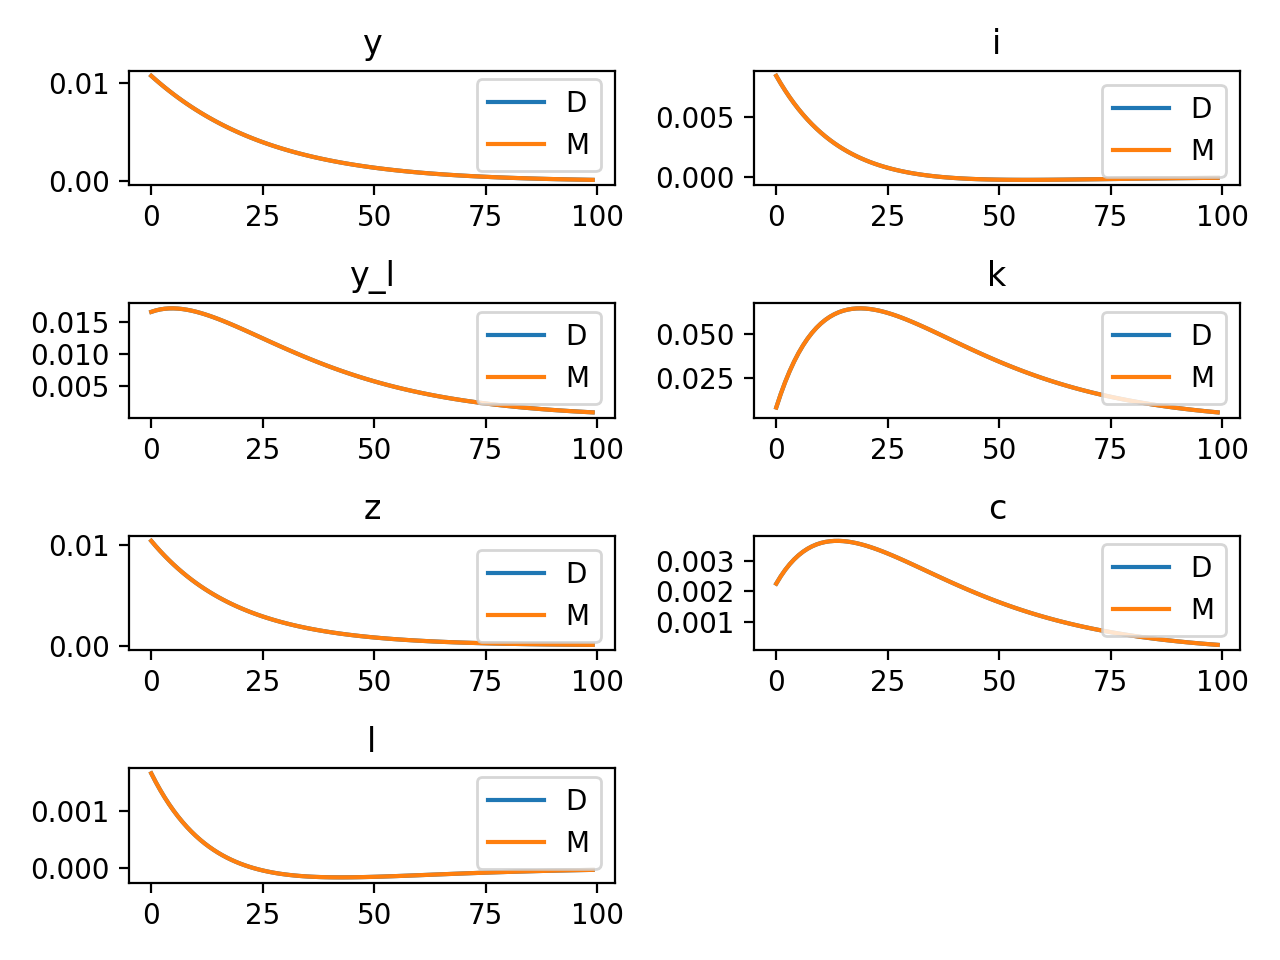

In [36]:
# Compare DYNARE++ irfp with ours (irf)
fig, axes = plt.subplots(nrows=4, ncols=2)
for idx_var, name_var in enumerate(irfp.columns):
    axis = axes.flat[idx_var]
    irfp.plot(y=irfp.columns[idx_var], 
                  ax=axis, 
                  label="D", 
                  title=irfp.columns[idx_var],
             )
    irf.plot(y=irf.columns[idx_var], 
                  ax=axis, 
                  label="M", 
                  title=irfp.columns[idx_var],
             )
fig.delaxes(axes.flat[-1]) # Delete redundant last axis
plt.tight_layout()

# References

User references:

* [DYNARE++ standalone C++ executable - tutorial](https://www.dynare.org/assets/dynare++/dynare++-tutorial.pdf)

    * [DYNARE (MATLAB/Octave) preprocessor manual](https://www.dynare.org/manual/)

    * [DYNARE++ standalone C++ executable - inside the black box](https://www.dynare.org/assets/dynare++/kord.pdf)

* [Scipy](https://scipy.org/)

    * [Input-output library](https://docs.scipy.org/doc/scipy/reference/io.html)